In [1]:
!pip install opendatasets

In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.4 MB/s eta 0:00:00


# Importing Libraries

In [3]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, f1_score, precision_score, recall_score ,accuracy_score
)

from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')


# Data Loading

In [4]:
od.download('https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mo7amed3bdelghany
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud


100%|██████████| 66.0M/66.0M [00:00<00:00, 1.29GB/s]

In [5]:
df = pd.read_csv('/content/creditcardfraud/creditcard.csv')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# file_path = '/content/drive/My Drive/Data/creditcard.csv'
# df = pd.read_csv(file_path)

# print("Dataset shape:", df.shape)
# print("Fraud distribution:\n", df['Class'].value_counts())
# print("Missing values total:", df.isnull().sum().sum())


Mounted at /content/drive
Dataset shape: (284807, 31)
Fraud distribution:
 Class
0    284315
1       492
Name: count, dtype: int64
Missing values total: 0


In [6]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [11]:
df.duplicated().sum()

np.int64(1081)

In [17]:
df.drop_duplicates(inplace=True)

# Exploratory Data Analysis

- Fraud Distribution

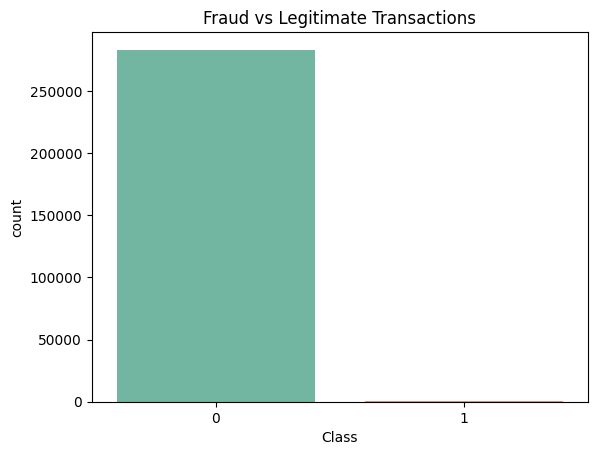

In [25]:
sns.countplot(x='Class', data=df, palette='Set2')
plt.title("Fraud vs Legitimate Transactions")
plt.show()

In [19]:
df.Class.value_counts()

,count
Class,
0,283253
1,473


- Correlation Matrix

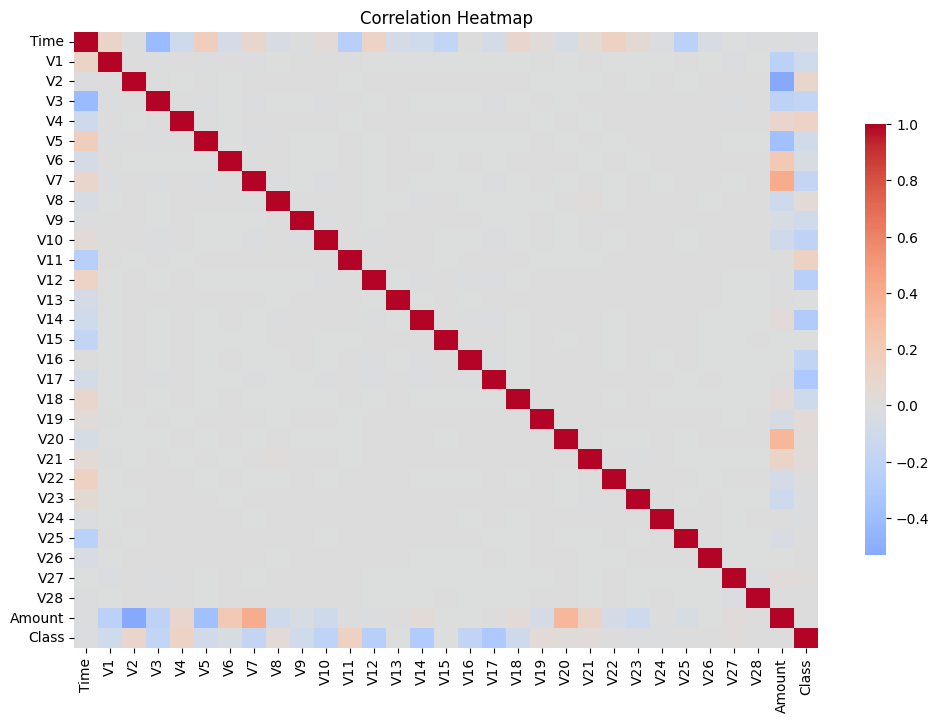

In [20]:
plt.figure(figsize=(12,8))
corr = df.corr()
sns.heatmap(corr, cmap="coolwarm", center=0, cbar_kws={'shrink':0.7})
plt.title("Correlation Heatmap")
plt.show()


<Axes: >

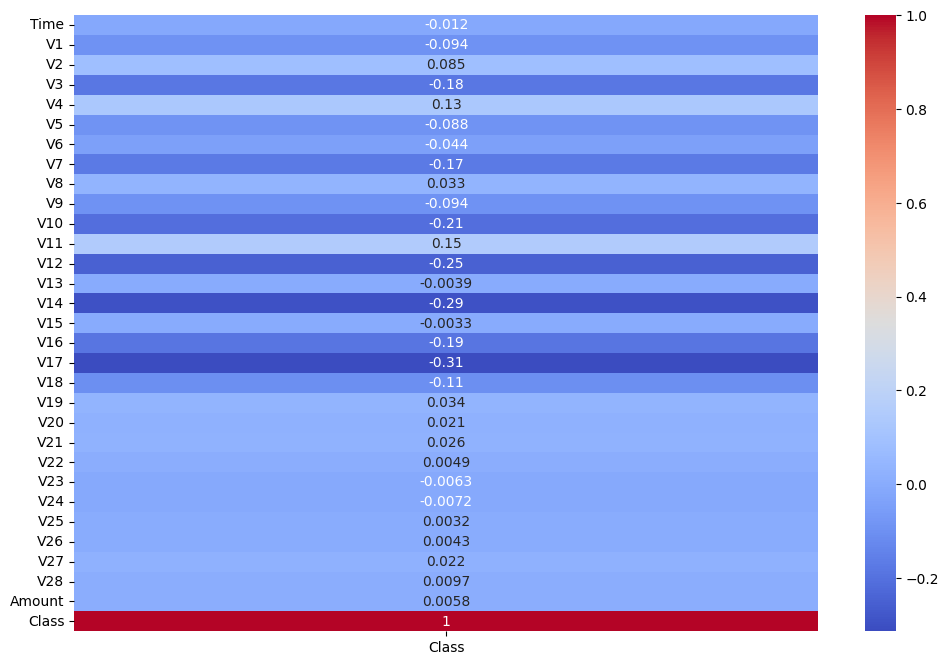

In [21]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr()['Class'].to_frame(), annot=True, cmap='coolwarm')

- Transaction Amount Distributionm

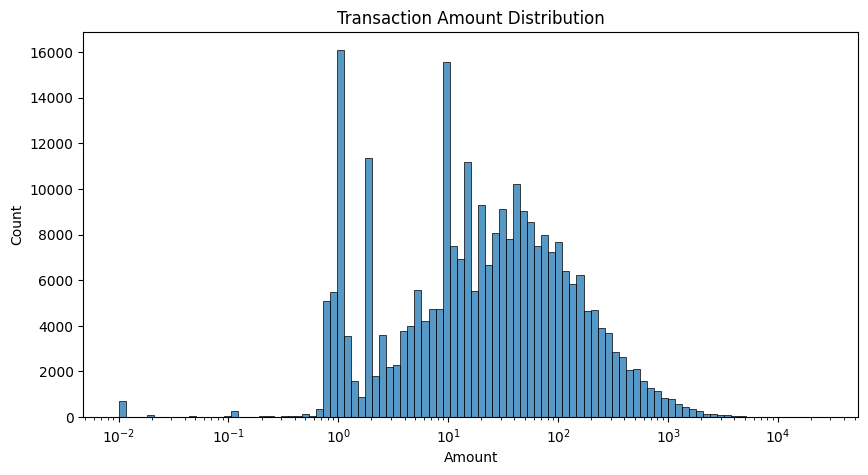

In [22]:
plt.figure(figsize=(10,5))
sns.histplot(df['Amount'], bins=100, log_scale=True, kde=False)
plt.title("Transaction Amount Distribution")
plt.show()


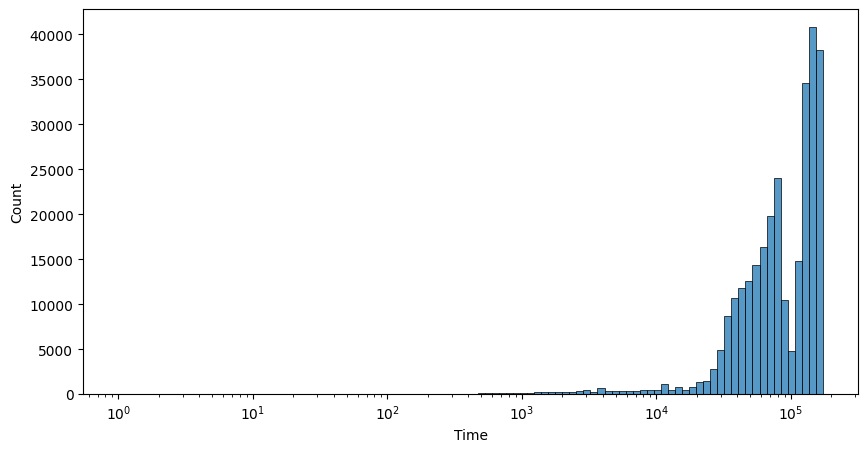

In [24]:
plt.figure(figsize=(10,5))
sns.histplot(df['Time'], bins=100, log_scale=True, kde=False)
plt.show()


In [26]:
df1 = df.copy()

# Feature Engineering

In [ ]:
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df[['Amount']])
df['scaled_time'] = scaler.fit_transform(df[['Time']])

df['hour_of_day'] = (df['Time'] % 86400) // 3600
df['time_bin'] = pd.cut(df['hour_of_day'], bins=[0, 6, 12, 18, 24],
                        labels=['night', 'morning', 'afternoon', 'evening'],
                        include_lowest=True)

df['amount_deviation'] = df['scaled_amount'] - df[df['Class'] == 0]['scaled_amount'].mean()
df['amount_bin'] = pd.qcut(df['scaled_amount'], q=4,
                           labels=['low', 'medium', 'high', 'very_high'])

df = pd.get_dummies(df, columns=['time_bin', 'amount_bin'], drop_first=True)

v_columns = [f'V{i}' for i in range(1, 29)]
df['mean_V'] = df[v_columns].mean(axis=1)
df['std_V'] = df[v_columns].std(axis=1)

numerical_cols = ['scaled_time', 'scaled_amount', 'hour_of_day', 'amount_deviation', 'mean_V', 'std_V'] + v_columns
corr = df[numerical_cols + ['Class']].corr()['Class'].abs().sort_values(ascending=False)
top_corr_features = corr[1:5].index.tolist()
for i, f1 in enumerate(top_corr_features[:2]):
    for f2 in top_corr_features[i+1:3]:
        df[f'{f1}_{f2}_interaction'] = df[f1] * df[f2]

df.drop(['Time', 'Amount'], axis=1, inplace=True)

cols = ['scaled_time', 'scaled_amount', 'hour_of_day', 'amount_deviation', 'mean_V', 'std_V'] + \
       [col for col in df.columns if col.startswith('V')] + \
       [col for col in df.columns if col.startswith('time_bin_') or col.startswith('amount_bin_')] + \
       [col for col in df.columns if '_interaction' in col] + ['Class']
df = df[cols]


# Visualizing Engineered Features

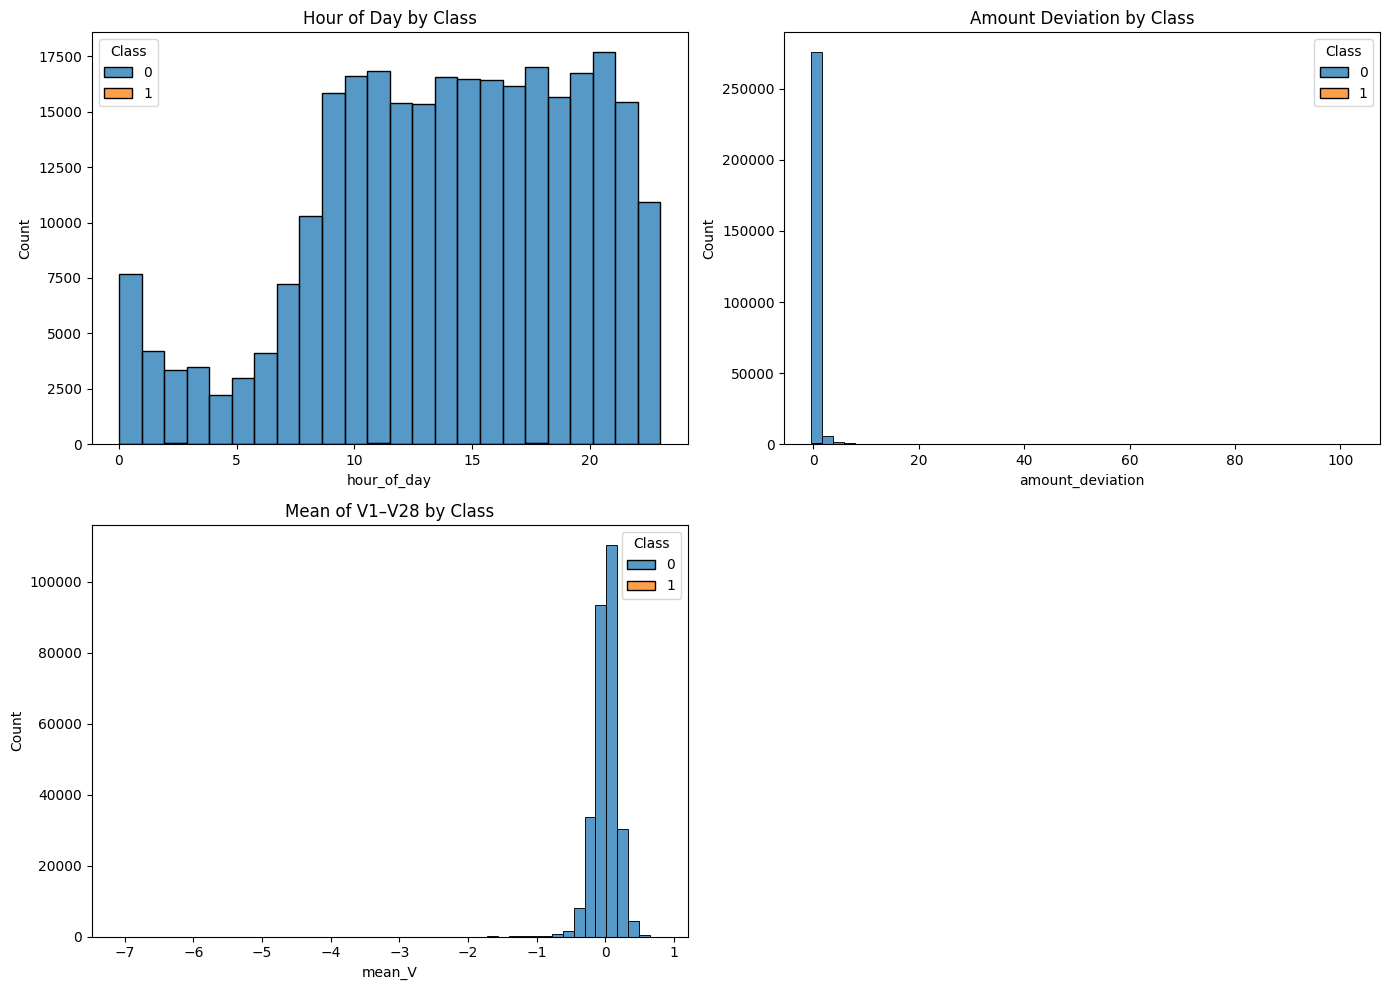

In [ ]:
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
sns.histplot(data=df, x='hour_of_day', hue='Class', bins=24, multiple='stack')
plt.title('Hour of Day by Class')

plt.subplot(2, 2, 2)
sns.histplot(data=df, x='amount_deviation', hue='Class', bins=50, multiple='stack')
plt.title('Amount Deviation by Class')

plt.subplot(2, 2, 3)
sns.histplot(data=df, x='mean_V', hue='Class', bins=50, multiple='stack')
plt.title('Mean of V1–V28 by Class')

plt.tight_layout()
plt.show()


# Train-Test Split

In [ ]:
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train set: {X_train.shape[0]} samples, Fraud cases: {y_train.sum()}")
print(f"Test set:  {X_test.shape[0]} samples, Fraud cases: {y_test.sum()}")


Train set: 227845 samples, Fraud cases: 394
Test set:  56962 samples, Fraud cases: 98


# Model Evaluation Helper

In [ ]:
def evaluate_model(model, X_test, y_test, model_name, threshold=0.5):
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    print(f"\n{'='*50}")
    print(f"=== {model_name} ===")
    print(f"{'='*50}")
    print(f"Classification Report (Threshold={threshold:.4f}):")
    print(classification_report(y_test, y_pred, target_names=['Legit', 'Fraud'], digits=4))

    roc_auc = roc_auc_score(y_test, y_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)

    print(f"\nKey Metrics:")
    print(f"   Accuracy:  {acc:.4f}")
    print(f"   ROC-AUC:   {roc_auc:.4f}")
    print(f"   PR-AUC:    {pr_auc:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   Recall:    {rec:.4f}")

    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legit', 'Fraud'],
                yticklabels=['Legit', 'Fraud'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return {
        'Accuracy': acc,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc,
        'F1': f1,
        'Precision': prec,
        'Recall': rec,
        'y_proba': y_proba
    }

def find_optimal_threshold(y_true, y_proba, beta=2.0):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    f_scores = (1 + beta**2) * (precisions * recalls) / (beta**2 * precisions + recalls + 1e-10)
    optimal_idx = np.argmax(f_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
    return optimal_threshold, f_scores[optimal_idx]



Performing 5-fold cross-validation...

Fold 1/5
Fold 1 Metrics: PR-AUC=0.8635, F1=0.8627, Accuracy : 0.9995 ,Precision=0.8800, Recall=0.8462, Threshold=0.4930

Fold 2/5
Fold 2 Metrics: PR-AUC=0.8189, F1=0.8392, Accuracy : 0.9995 ,Precision=0.9375, Recall=0.7595, Threshold=0.9569

Fold 3/5
Fold 3 Metrics: PR-AUC=0.8257, F1=0.8344, Accuracy : 0.9995 ,Precision=0.8750, Recall=0.7975, Threshold=0.6734

Fold 4/5
Fold 4 Metrics: PR-AUC=0.8882, F1=0.8696, Accuracy : 0.9995 ,Precision=0.8537, Recall=0.8861, Threshold=0.9392

Fold 5/5
Fold 5 Metrics: PR-AUC=0.8415, F1=0.8767, Accuracy : 0.9996 ,Precision=0.9552, Recall=0.8101, Threshold=0.9969

Cross-Validation Results (Stacking Ensemble + SMOTE)
Accuracy     0.9995
ROC-AUC      0.9825
PR-AUC       0.8475
F1           0.8565
Precision    0.9003
Recall       0.8199
Threshold    0.8119
dtype: float64

Std of Metrics:
Accuracy     0.0001
ROC-AUC      0.0094
PR-AUC       0.0285
F1           0.0187
Precision    0.0437
Recall       0.0483
Threshold 

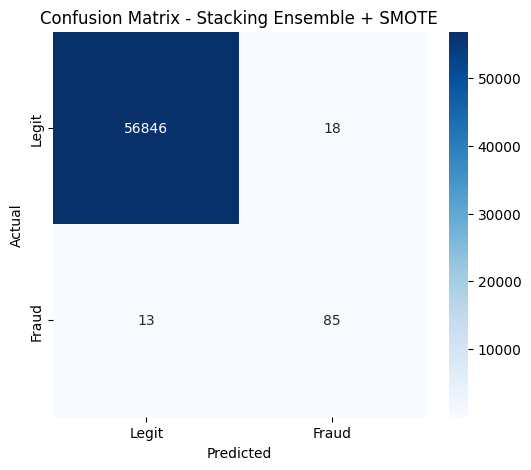


Optimal Threshold for 'Stacking Ensemble + SMOTE': 0.9821 (Max F1=0.8696)

=== Stacking Ensemble + SMOTE (Optimized Threshold) ===
Classification Report (Threshold=0.9821):
              precision    recall  f1-score   support

       Legit     0.9998    0.9999    0.9998     56864
       Fraud     0.9231    0.8571    0.8889        98

    accuracy                         0.9996     56962
   macro avg     0.9614    0.9285    0.9444     56962
weighted avg     0.9996    0.9996    0.9996     56962


Key Metrics:
   Accuracy:  0.9996
   ROC-AUC:   0.9847
   PR-AUC:    0.8711
   F1-Score:  0.8889
   Precision: 0.9231
   Recall:    0.8571


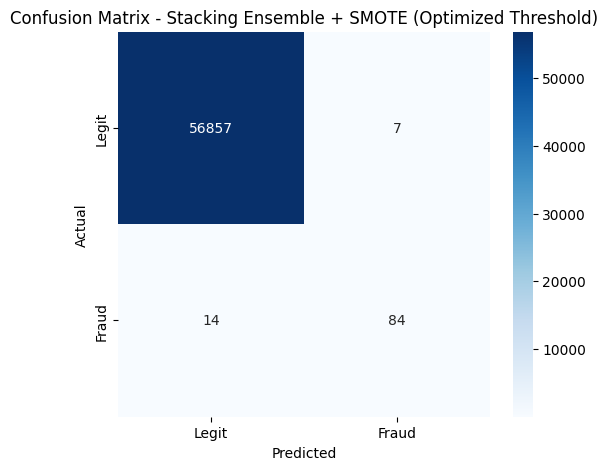


Training and evaluation completed!


In [ ]:
base_models = [
    ('xgb', xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1)),
    ('cat', CatBoostClassifier(iterations=100, depth=5, learning_rate=0.1, random_state=42, verbose=0)),
    ('lgb', lgb.LGBMClassifier(n_estimators=100, max_depth=7, learning_rate=0.1, random_state=42, n_jobs=-1, min_child_samples=10,verbose=-1))
]

meta_model = LogisticRegression(random_state=42)
stacking_classifier = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)


stacking_smote_pipeline = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('smote', SMOTE(sampling_strategy=0.1, random_state=42)),
    ('classifier', stacking_classifier)
])


cv_results = {
    'Accuracy':[],
    'ROC-AUC': [],
    'PR-AUC': [],
    'F1': [],
    'Precision': [],
    'Recall': [],
    'Threshold': []
}

print("\nPerforming 5-fold cross-validation...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print(f"\nFold {fold}/5")
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]


    stacking_smote_pipeline.fit(X_tr, y_tr)


    y_proba = stacking_smote_pipeline.predict_proba(X_val)[:, 1]


    opt_thresh, opt_f1 = find_optimal_threshold(y_val, y_proba, beta=2.0)
    y_pred = (y_proba >= opt_thresh).astype(int)


    Accuracy = accuracy_score(y_val,y_pred)
    roc_auc = roc_auc_score(y_val, y_proba)
    precision, recall, _ = precision_recall_curve(y_val, y_proba)
    pr_auc = auc(recall, precision)
    f1 = f1_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    cv_results['Accuracy'].append(Accuracy)
    cv_results['ROC-AUC'].append(roc_auc)
    cv_results['PR-AUC'].append(pr_auc)
    cv_results['F1'].append(f1)
    cv_results['Precision'].append(prec)
    cv_results['Recall'].append(rec)
    cv_results['Threshold'].append(opt_thresh)

    print(f"Fold {fold} Metrics: PR-AUC={pr_auc:.4f}, F1={f1:.4f}, Accuracy : {Accuracy:.4f} ,Precision={prec:.4f}, Recall={rec:.4f}, Threshold={opt_thresh:.4f}")


cv_results_df = pd.DataFrame(cv_results)
print("\n" + "="*80)
print("Cross-Validation Results (Stacking Ensemble + SMOTE)")
print("="*80)
print(cv_results_df.mean().round(4))
print("\nStd of Metrics:")
print(cv_results_df.std().round(4))


print("\nTraining model on full training set...")
stacking_smote_pipeline.fit(X_train, y_train)


metrics = evaluate_model(stacking_smote_pipeline, X_test, y_test, 'Stacking Ensemble + SMOTE', threshold=0.5)


y_proba_best = stacking_smote_pipeline.predict_proba(X_test)[:, 1]
opt_thresh, opt_f1 = find_optimal_threshold(y_test, y_proba_best, beta=2.0)
print(f"\nOptimal Threshold for 'Stacking Ensemble + SMOTE': {opt_thresh:.4f} (Max F1={opt_f1:.4f})")
metrics_opt = evaluate_model(stacking_smote_pipeline, X_test, y_test, 'Stacking Ensemble + SMOTE (Optimized Threshold)', threshold=opt_thresh)

print("\nTraining and evaluation completed!")

# Save Model

In [ ]:
import joblib
from typing import Dict, Union, List, Tuple


joblib.dump(stacking_smote_pipeline, '/content/drive/My Drive/Data/fraud_model_pipeline.pkl')


joblib.dump(scaler, '/content/drive/My Drive/Data/scaler.pkl')

legit_amount_mean = df[df['Class'] == 0]['scaled_amount'].mean()
joblib.dump(legit_amount_mean, '/content/drive/My Drive/Data/legit_amount_mean.pkl')


amount_bin_quantiles = df['scaled_amount'].quantile([0, 0.25, 0.5, 0.75, 1]).values
joblib.dump(amount_bin_quantiles, '/content/drive/My Drive/Data/amount_bin_edges.pkl')


numerical_cols = ['scaled_time', 'scaled_amount', 'hour_of_day', 'amount_deviation', 'mean_V', 'std_V'] + [f'V{i}' for i in range(1, 29)]
corr = df[numerical_cols + ['Class']].corr()['Class'].abs().sort_values(ascending=False)
top_corr_features = corr[1:5].index.tolist()
joblib.dump(top_corr_features, '/content/drive/My Drive/Data/top_corr_features.pkl')

joblib.dump(opt_thresh, '/content/drive/My Drive/Data/optimal_threshold.pkl')


joblib.dump(X_train.columns.tolist(), '/content/drive/My Drive/Data/feature_columns.pkl')

print("All artifacts saved to Google Drive!")

All artifacts saved to Google Drive!
